In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(20, 10)})
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")
from pmdarima import auto_arima 
import pandas as pd 
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm

In [2]:
df = pd.read_csv('../datatest/monthly-car-sales.csv')

In [3]:
df.head()


,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026
3,1960-04,14395
4,1960-05,14587


<AxesSubplot:>

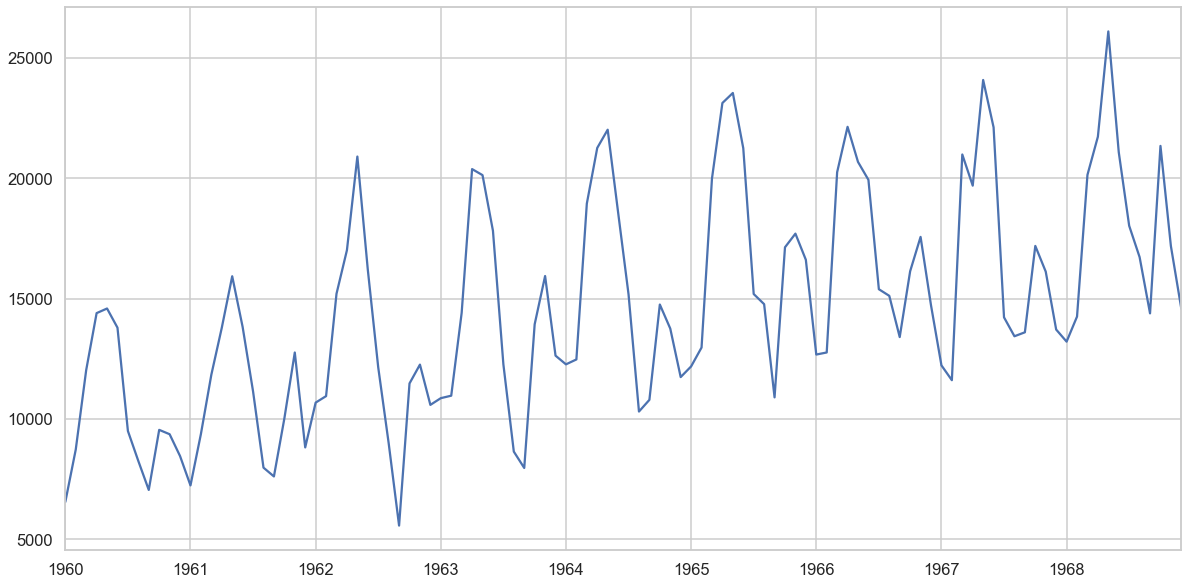

In [4]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
df['Sales'].plot()


Задание №1 
-------
Разложить на компоненты, используя функцию <code>seasonal_decompose</code>

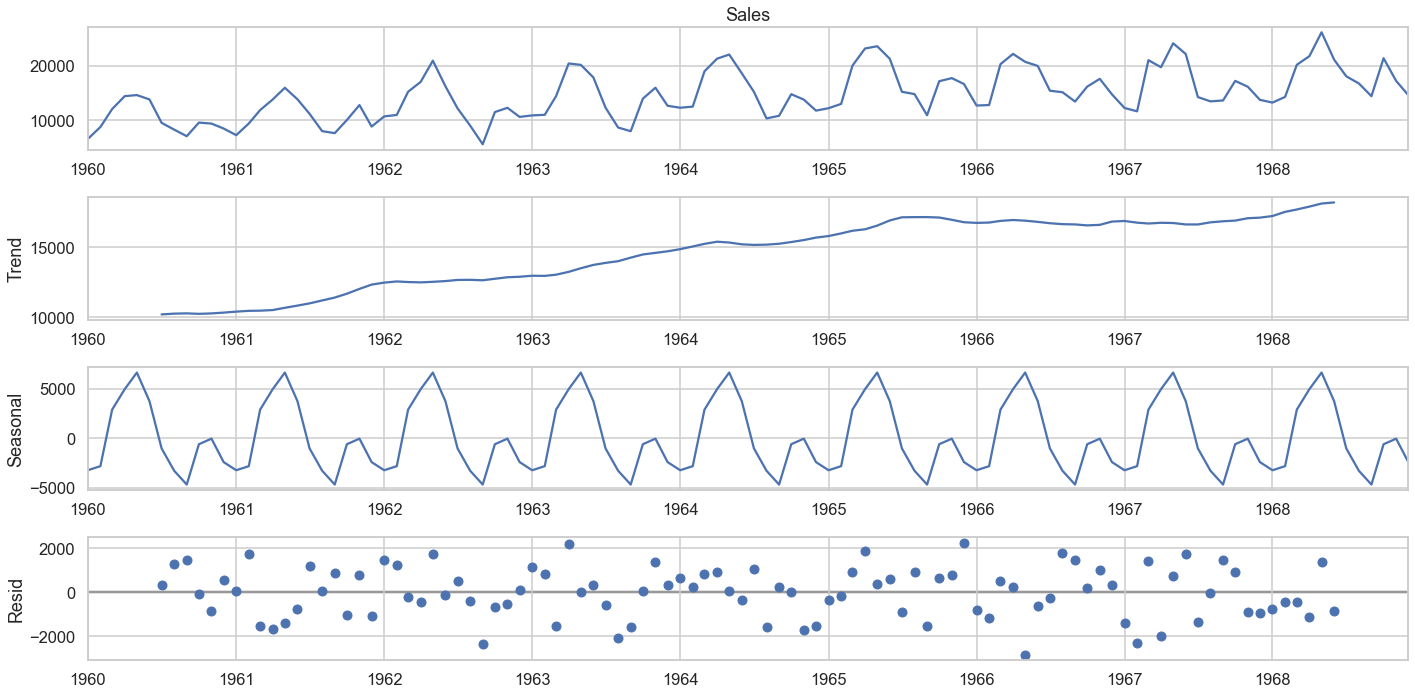

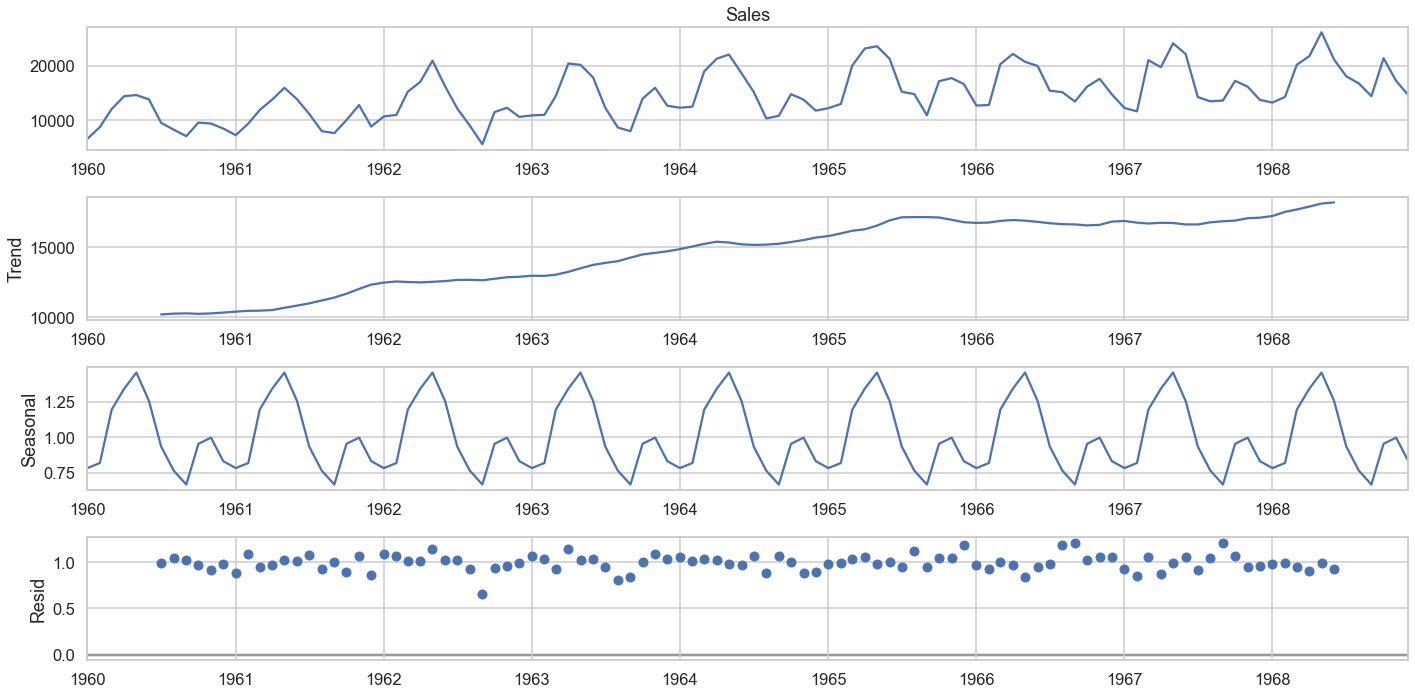

In [6]:
decomposition1 = sm.tsa.seasonal_decompose(df.Sales, model='additive')
decomposition2 = sm.tsa.seasonal_decompose(df.Sales, model='multiplicative') # additive seasonal index
fig = decomposition1.plot(), decomposition2.plot()
plt.show()


Проверим, является ли временной ряд стационарным. 

In [7]:
result = adfuller(df['Sales'])
print('p-value: %f' % result[1])

p-value: 0.663269


Ряд не стационарный, попробуем сделать одну дифференциацию.

In [8]:
df['diff'] = df['Sales'].diff()
df.dropna(inplace=True)

result = adfuller(df['diff'])
print('p-value: %f' % result[1])

p-value: 0.000000


Ну теперь p-значение нулевое, из этого можно сделать вывод ,что ряд стал стационарным, больше можно не дифференциировать 

<AxesSubplot:>

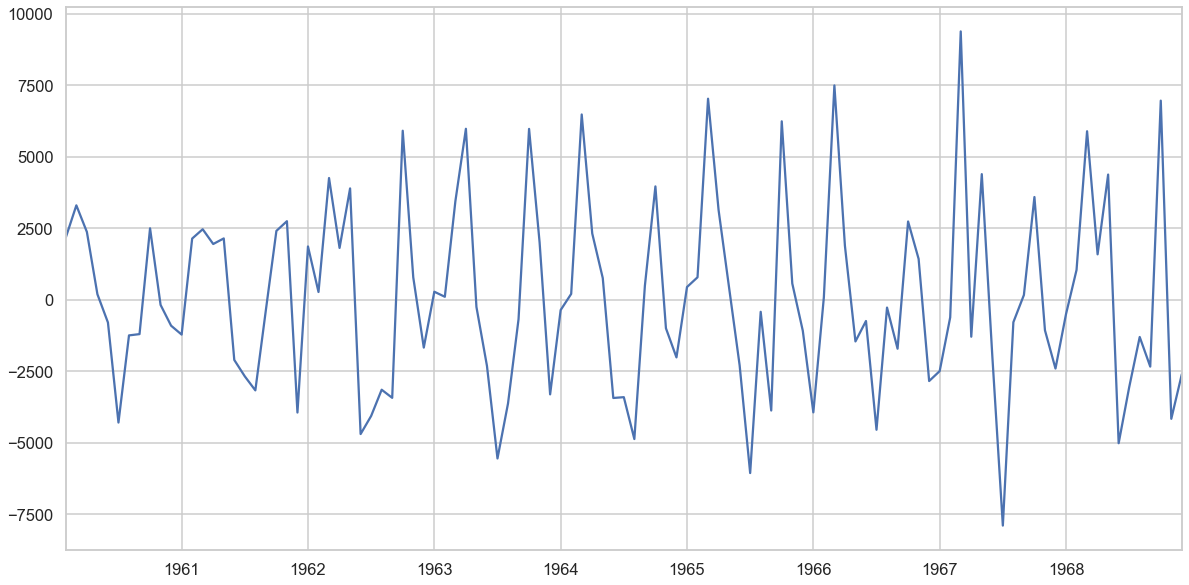

In [9]:
df['diff'].plot()

Задание №2
------
Сделать графики авто корреляции и часточной автокорреляции с помощью функций <code> plot_acf </code> и <code> plot_pacf </code>.

Если при использовании функции <code> plot_pacf </code> появляется ошибка <code>RuntimeWarning: invalid value encountered in sqrt</code> , можно изменить дефолтное значение метода, используемого для рассчета частичной автокорреляции. Почитать про методы можно почитать здесь:
<a>https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html</a>

Попробуйте использовать <code> method = 'ldadjusted' </code>

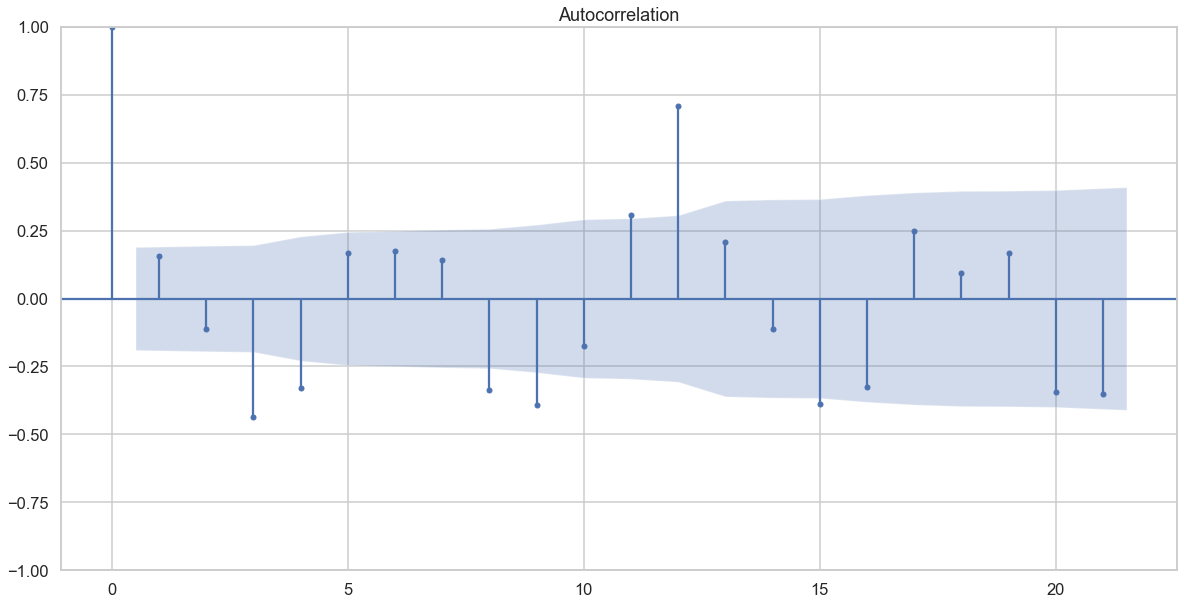

In [10]:
plot_acf(df['diff'])
plt.show();


In [11]:
Хорошо видно, что корреляция самая хорошая с тем же месяцем, тоесть параметр p=12

SyntaxError: invalid syntax (2465848240.py, line 1)

C:\Users\kate\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


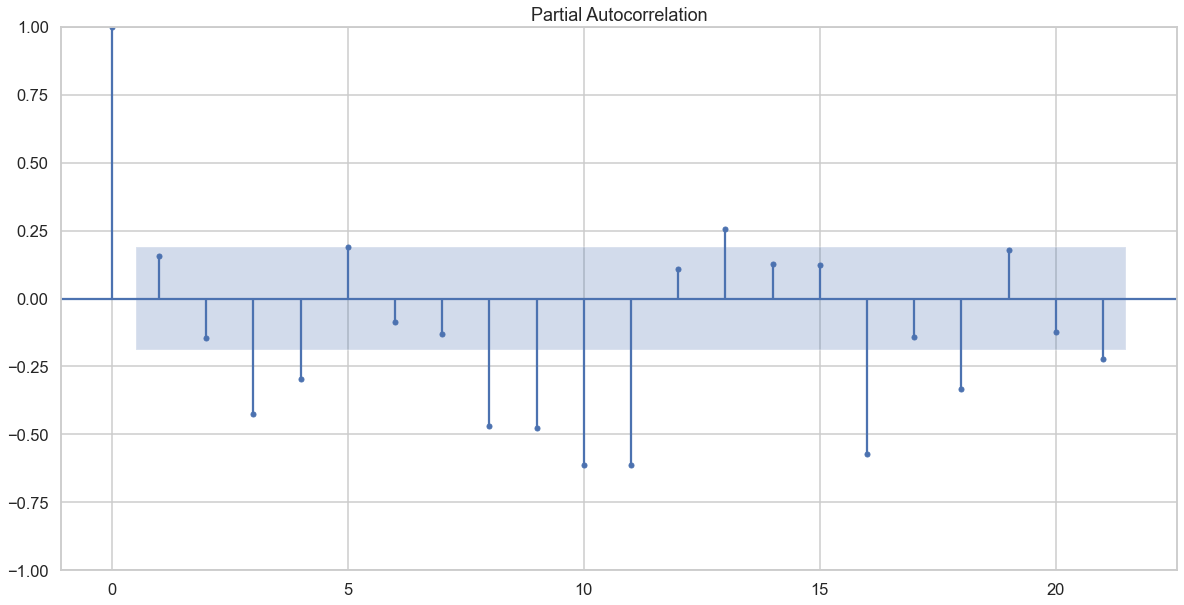

In [12]:
plot_pacf(df['diff'])
plt.show();

Частичная корреляция показывает, что p может быть 10 или 11

In [13]:
del df['diff'] # больше не нужно, Arima и так дифференецирует на заноное в d количество раз

size = int(len(df)*0.8)
train, test = df[0:size], df[size:]
print(f'Length of train is {len(train)} and lenght of test is {len(test)}')


Length of train is 85 and lenght of test is 22


In [23]:
model = ARIMA(train['Sales'], order=(5,1,12))
model_fit = model.fit()

predictions = model_fit.forecast(len(test))
Arima_r2score = r2_score(test, predictions)
Arima_mae = np.round(mean_absolute_error(test, predictions),2)
Arima_score, Arima_mae

C:\Users\kate\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\kate\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0.05966336794374971, 2854.49)

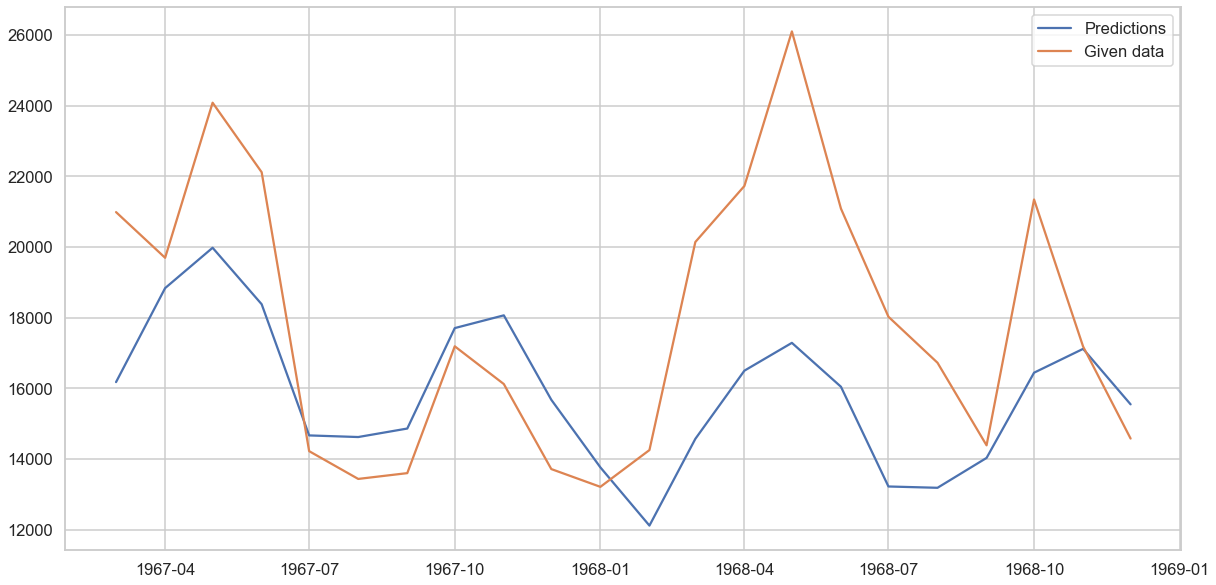

In [15]:
fig, ax = plt.subplots()
ax.plot(predictions, label = 'Predictions')
ax.plot(test['Sales'], label = 'Given data')
plt.legend()
plt.show()

Задание №3
===
Используя <code>auto_arima</code> найти оптимальный набор параметров, натренировать на нем модель (на тренировочных данных) и сделать прогноз для теста. Сделать графики и посчитать качество предсказаний, используя метрики <code> r2_score </code> и <code> mean_absolute_error </code>.

In [16]:
AutoARIMA_model = auto_arima(train["Sales"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
AutoARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   85
Model:             SARIMAX(0, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -632.956
Date:                                 Tue, 21 Jun 2022   AIC                           1273.913
Time:                                         23:40:22   BIC                           1283.019
Sample:                                              0   HQIC                          1277.538
                                                  - 85                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6603      0.100     -6.630      0.000      -0.855      -0.465
ma.S.L12      -0.3336      0.129     -2.585      0.010      -0.586      -0.081
ma.S.L24       0.2380      0.145      1.638      0.101      -0.047       0.523
sigma2      2.416e+06   4.38e+05      5.518      0.000    1.56e+06    3.27e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.98   Prob(JB):                         0.62
Heteroskedasticity (H):               1.07   Skew:                             0.25
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\kate\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


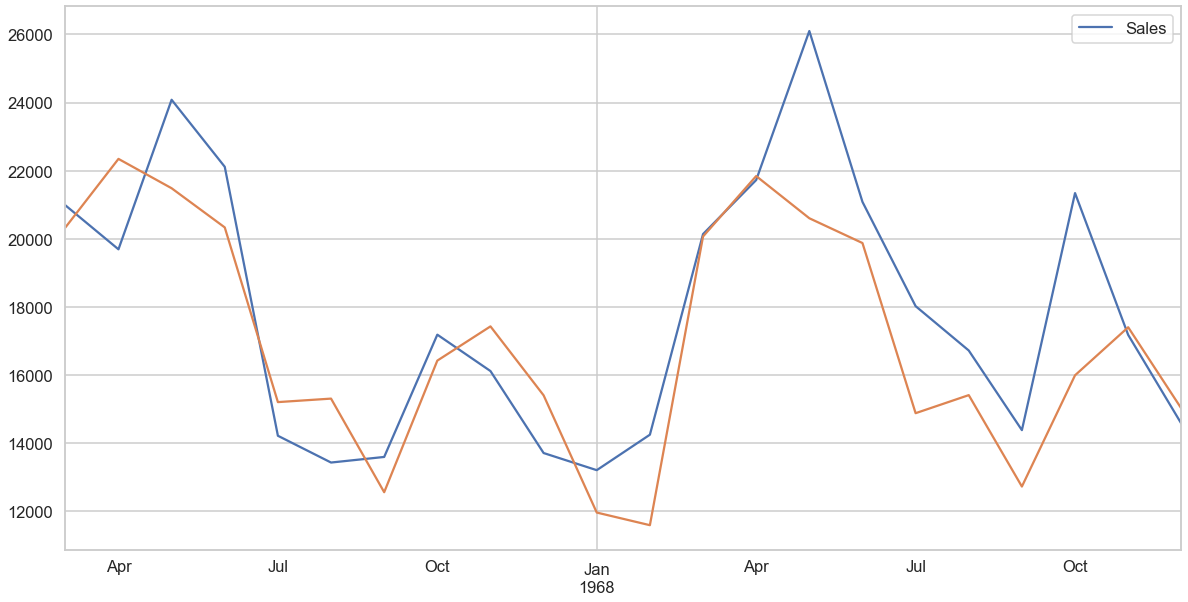

In [24]:
order = (0,1,1)
seasonal_order = (0,1,[1,2],12)

SARIMA_model = ARIMA(train, order=order, seasonal_order=seasonal_order)

SARIMA_model_fit = SARIMA_model.fit()

predictions = SARIMA_model_fit.forecast(len(test))
Sarima_r2score = r2_score(test, predictions)
Sarima_mae = np.round(mean_absolute_error(test, predictions),2)
test.plot()
predictions.plot()
plt.show() 


In [19]:
Arima_r2score, Sarima_r2score

(0.05966336794374971, 0.6417245280281927)

In [25]:
Arima_mae, Sarima_mae

(2854.49, 1739.2)

При сравнении метрик видно, что ошибка уменьшилась(хотя и осталась очень большой) и модель стала лучше